In [13]:
# plt.rcParams['text.usetex'] = True

from evaluation.strategies import (
    PredictionCoverageStrategy,
    MAEStrategy,
    PrecisionAtKStrategy,
    RecallAtKStrategy,
    NDCGStrategy,
)

class TotalTimeStrategyMock():

    @staticmethod
    def get_name() -> str:
        return "total_time"

    @staticmethod
    def is_better_higher() -> bool:
        return False

In [38]:
# Load Raw Data

import json

# Adversary Models
with open('hyperparameter_search/movielens_100k/IB_BBCF_VANILLA_grid_raw.results', 'r') as file_object:
    IB_BBCF_VANILLA = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UB_BBCF_VANILLA_grid_raw.results', 'r') as file_object:
    UB_BBCF_VANILLA = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IBKNN_grid_raw.results', 'r') as file_object:
    IBKNN = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UBKNN_grid_raw.results', 'r') as file_object:
    UBKNN = json.load(file_object)

with open('hyperparameter_search/movielens_100k/SVD_grid_raw.results', 'r') as file_object:
    SVD = json.load(file_object)

with open('hyperparameter_search/movielens_100k/SVD++_grid_raw.results', 'r') as file_object:
    SVDpp = json.load(file_object)


# My Models
with open('hyperparameter_search/movielens_100k/IB_BBCF_COSINE_grid_raw.results', 'r') as file_object:
    IB_BBCF_COSINE = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UB_BBCF_COSINE_grid_raw.results', 'r') as file_object:
    UB_BBCF_COSINE = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IB_BBCF_COSINE_DOUBLE_WEIGHT_grid_raw.results', 'r') as file_object:
    IB_BBCF_COSINE_DOUBLE_WEIGHT = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UB_BBCF_COSINE_DOUBLE_WEIGHT_grid_raw.results', 'r') as file_object:
    UB_BBCF_COSINE_DOUBLE_WEIGHT = json.load(file_object)

with open('hyperparameter_search/movielens_100k/IB_BBCF_BINAPS_grid_raw.results', 'r') as file_object:
    IB_BBCF_BINAPS = json.load(file_object)

with open('hyperparameter_search/movielens_100k/UB_BBCF_BINAPS_grid_raw.results', 'r') as file_object:
    UB_BBCF_BINAPS = json.load(file_object)

def combine_solutions(labeled_solutions):
    combined_solutions = []
    for label, solutions in labeled_solutions:
        for solution in solutions:
            solution[0]["name"] = label
        combined_solutions += solutions
    return combined_solutions

def remove_impossible_solution(solutions):
    possible_solutions = []
    for solution in solutions:
        metrics = solution[1]

        impossible = any(None in values for key, values in metrics.items())
        if not impossible:
            possible_solutions.append(solution)
    return possible_solutions

IB_BBCF_BINAPS = remove_impossible_solution(IB_BBCF_BINAPS)
UB_BBCF_BINAPS = remove_impossible_solution(UB_BBCF_BINAPS)


all_solutions = [
    ("SVD", SVD),
    ("SVD++", SVDpp),
    ("CF IB", IBKNN),
    ("CF UB", UBKNN),
    ("IB BBCF", IB_BBCF_VANILLA),
    ("UB BBCF", UB_BBCF_VANILLA),
    ("UB BBCF + CS", UB_BBCF_COSINE),
    ("IB BBCF + CS", IB_BBCF_COSINE),
    ("IB BBCF + CS + CWF", IB_BBCF_COSINE_DOUBLE_WEIGHT),
    ("UB BBCF + CS + CWF", UB_BBCF_COSINE_DOUBLE_WEIGHT),
    ("IB BBCF + BMS", IB_BBCF_BINAPS),
    ("UB BBCF + BMS", UB_BBCF_BINAPS),
]
combined_solutions = combine_solutions(all_solutions)
labels = [label for label, _ in all_solutions]

for param, metrics in combined_solutions:
    total_time = [fit_time + test_time for fit_time, test_time in zip(metrics['fit_time'], metrics['test_time'])]
    metrics['total_time'] = total_time

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def dominates(a, b, objectives):

    partial_result = []
    for objective in objectives:
        direction = 1 if objective.is_better_higher() else -1

        a_mean = np.mean(a[objective.get_name()])
        b_mean = np.mean(b[objective.get_name()])

        if direction * a_mean >= direction * b_mean:
            partial_result.append(True)
        else:
            partial_result.append(False)

    return all(partial_result)


def get_all_strongly_dominated_solutions(solution, solutions, objectives):
    return [id for id, s in enumerate(solutions) if dominates(solution[1], s[1], objectives)]


def remove_indices(lst, indices):
    list_with_indices_removed = [el for i, el in enumerate(lst) if i not in indices]
    indices_removed = [el for i, el in enumerate(lst) if i in indices]
    return list_with_indices_removed, indices_removed


def get_pareto_frontier(solutions, objectives):

    pareto_frontier = solutions
    dominated_solutions = []

    searching = True
    while searching:
        for solution_id, solution in enumerate(pareto_frontier):

            pareto_frontier_without_solution = [
                s for i, s in enumerate(pareto_frontier) if i != solution_id
            ]

            strongly_dominated_solutions = get_all_strongly_dominated_solutions(
                solution, pareto_frontier_without_solution, objectives
            )
            if strongly_dominated_solutions:
                pareto_frontier_without_solution, removed = remove_indices(
                    pareto_frontier_without_solution, strongly_dominated_solutions
                )
                pareto_frontier_without_solution.append(solution)
                pareto_frontier = pareto_frontier_without_solution
                dominated_solutions += removed
                break
        else:
            searching = False

    return pareto_frontier, dominated_solutions


def filter_solutions_that_guarantee_minimum(solutions, metric, value):
    filtered = []
    for parameters, metrics in solutions:
        if np.mean(metrics[metric]) >= value:
            filtered.append((parameters, metrics))
    return filtered


def filter_solutions(solutions, fixed_parameters):
    filtered = []
    for parameters, metrics in solutions:

        for key, value in fixed_parameters.items():

            if type(value) == dict:

                to_break = False

                for sub_key, sub_value in value.items():
                    if parameters[key][sub_key] != sub_value:
                        to_break = True
                        break

                if to_break:
                    break

            else:
                if parameters[key] != value:
                    break
        else:
            filtered.append((parameters, metrics))

    return filtered


def sort_pareto_frontier(pareto_frontier, labels):
    sorted_pareto_frontier = {}
    for label in labels:
        sorted_pareto_frontier[label] = []

    for solution in pareto_frontier:
        sorted_pareto_frontier[solution[0]["name"]].append(solution)

    return sorted_pareto_frontier


def add_frontier(axis, pareto_frontier, color, name, objectives, makers=False):

    objective_1_name = objectives[0].get_name()

    objective_2_name = objectives[1].get_name()

    objective_1 = [np.mean(execution[1][objective_1_name]) for execution in pareto_frontier]
    objective_2 = [np.mean(execution[1][objective_2_name]) for execution in pareto_frontier]

    sorted_ids = np.argsort(objective_1)

    objective_1 = [objective_1[i] for i in sorted_ids]
    objective_2 = [objective_2[i] for i in sorted_ids]

    if makers:
        axis.plot(objective_1, objective_2, label=name, color=color, linewidth=3, marker="v", markersize=10)
    else:
        axis.plot(objective_1, objective_2, label=name, color=color, linewidth=3)


def add_scatter(axis, solutions, color, label, objectives):

    objective_1_name = objectives[0].get_name()

    objective_2_name = objectives[1].get_name()

    objective_1 = [np.mean(execution[1][objective_1_name]) for execution in solutions]
    objective_2 = [np.mean(execution[1][objective_2_name]) for execution in solutions]

    axis.scatter(
        objective_1,
        objective_2,
        label=label,
        color=color,
        s=80,
        zorder=2,
        marker="v",
    )


color_map = {
    "SVD": "deepskyblue",
    "SVD++": "magenta",
    "CF IB": "lime",
    "CF UB": "orangered",
    "IB BBCF": "blueviolet",
    "UB BBCF": "hotpink",
    "UB BBCF + CS": "gold",
    "IB BBCF + CS": "brown",
    "IB BBCF + CS + CWF": "gray",
    "UB BBCF + CS + CWF": "aquamarine",
    "IB BBCF + BMS": "navy",
    "UB BBCF + BMS": "teal",
}

pretty_names = {
    "mae": "MAE",
    "precision_at_k": "Precision@20",
    "recall_at_k": "Recall@20",
    "nDCG_at_k": "nDCG@20",
    "prediction_coverage": "Prediction Coverage",
    "total_time": "Total Time (s)",
}

In [4]:
plt.rcParams['font.size'] = 14  # Set the default font size
figure_size = (12, 5)

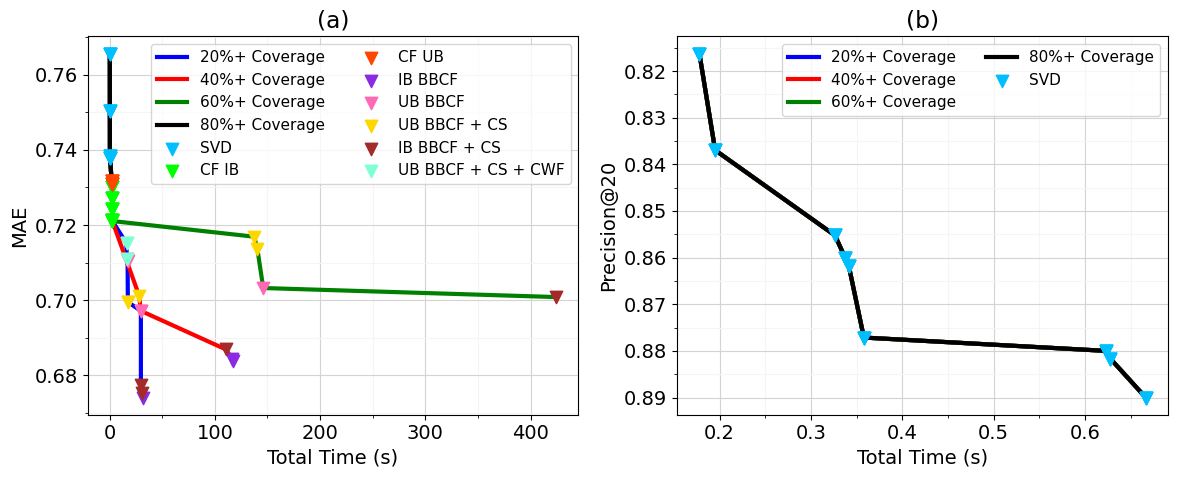

In [28]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)


objectives_list = [[TotalTimeStrategyMock, MAEStrategy], [TotalTimeStrategyMock, PrecisionAtKStrategy]]


for axis_id, objectives in enumerate(objectives_list):
    solutions_with_20_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.2,
    )
    pareto_with_20_coverage, _ = get_pareto_frontier(solutions_with_20_coverage, objectives)

    solutions_with_40_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.4,
    )
    pareto_with_40_coverage, _ = get_pareto_frontier(solutions_with_40_coverage, objectives)

    solutions_with_60_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.6,
    )
    pareto_with_60_coverage, _ = get_pareto_frontier(solutions_with_60_coverage, objectives)

    solutions_with_80_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.8,
    )
    pareto_with_80_coverage, _ = get_pareto_frontier(solutions_with_80_coverage, objectives)


    add_frontier(axis[axis_id], pareto_with_20_coverage, "blue", "20%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_40_coverage, "red", "40%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_60_coverage, "green", "60%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_80_coverage, "black", "80%+ Coverage", objectives)


    sorted_pareto = sort_pareto_frontier(
        pareto_with_20_coverage
        + pareto_with_40_coverage
        + pareto_with_60_coverage
        + pareto_with_80_coverage,
        labels,
    )

    for label, solutions in sorted_pareto.items():
        if len(solutions) > 0:
            add_scatter(axis[axis_id], solutions, color_map[label], label, objectives, )

    if objectives[0].is_better_higher():
        axis[axis_id].invert_xaxis()

    if objectives[1].is_better_higher():
        axis[axis_id].invert_yaxis()

    axis[axis_id].set_xlabel(pretty_names[objectives[0].get_name()])
    axis[axis_id].set_ylabel(pretty_names[objectives[1].get_name()])

    axis[axis_id].legend(loc="upper right", ncol=2, fontsize=11)
    axis[axis_id].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  # Draw 2 minor grid lines per major grid line on the x-axis
    axis[axis_id].yaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
    axis[axis_id].grid(True, which='major', color='lightgray')
    axis[axis_id].grid(True, which='minor', color='whitesmoke') 

    axis[axis_id].set_title("(a)" if axis_id == 0 else "(b)", loc='center')


plt.tight_layout()
# plt.show()
# plt.savefig("image.png", dpi=100, bbox_inches='tight', pad_inches = 0.01)
plt.savefig("image.png", dpi=150)


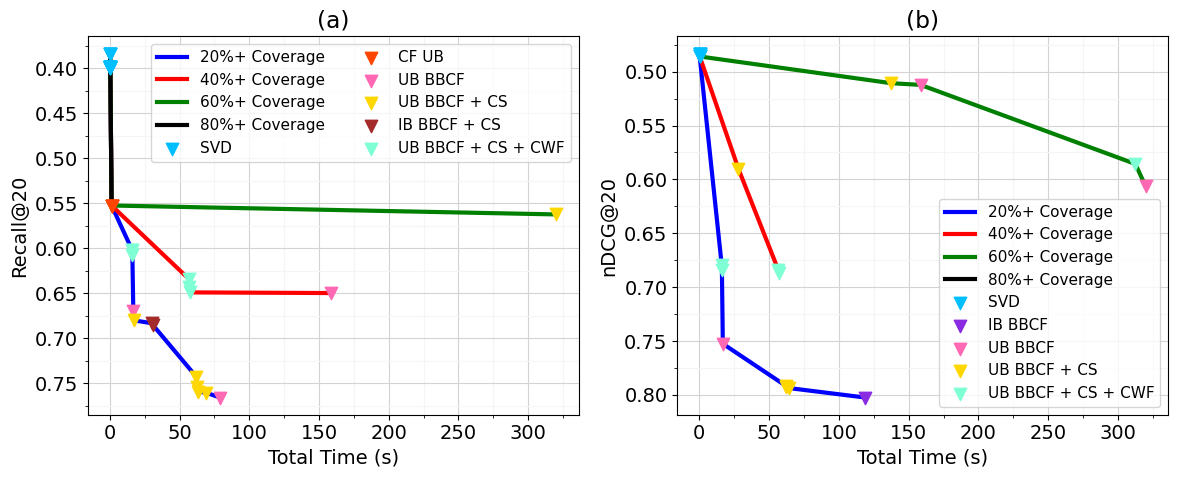

In [27]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)


objectives_list = [[TotalTimeStrategyMock, RecallAtKStrategy], [TotalTimeStrategyMock, NDCGStrategy]]


for axis_id, objectives in enumerate(objectives_list):
    solutions_with_20_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.2,
    )
    pareto_with_20_coverage, _ = get_pareto_frontier(solutions_with_20_coverage, objectives)

    solutions_with_40_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.4,
    )
    pareto_with_40_coverage, _ = get_pareto_frontier(solutions_with_40_coverage, objectives)

    solutions_with_60_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.6,
    )
    pareto_with_60_coverage, _ = get_pareto_frontier(solutions_with_60_coverage, objectives)

    solutions_with_80_coverage = filter_solutions_that_guarantee_minimum(
        combined_solutions,
        "prediction_coverage",
        0.8,
    )
    pareto_with_80_coverage, _ = get_pareto_frontier(solutions_with_80_coverage, objectives)


    add_frontier(axis[axis_id], pareto_with_20_coverage, "blue", "20%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_40_coverage, "red", "40%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_60_coverage, "green", "60%+ Coverage", objectives)
    add_frontier(axis[axis_id], pareto_with_80_coverage, "black", "80%+ Coverage", objectives)


    sorted_pareto = sort_pareto_frontier(
        pareto_with_20_coverage
        + pareto_with_40_coverage
        + pareto_with_60_coverage
        + pareto_with_80_coverage,
        labels,
    )

    for label, solutions in sorted_pareto.items():
        if len(solutions) > 0:
            add_scatter(axis[axis_id], solutions, color_map[label], label, objectives, )

    if objectives[0].is_better_higher():
        axis[axis_id].invert_xaxis()

    if objectives[1].is_better_higher():
        axis[axis_id].invert_yaxis()

    axis[axis_id].set_xlabel(pretty_names[objectives[0].get_name()])
    axis[axis_id].set_ylabel(pretty_names[objectives[1].get_name()])

    axis[axis_id].legend(loc="upper right", ncol=2, fontsize=11)
    axis[axis_id].xaxis.set_minor_locator(ticker.AutoMinorLocator(2))  
    axis[axis_id].yaxis.set_minor_locator(ticker.AutoMinorLocator(2)) 
    axis[axis_id].grid(True, which='major', color='lightgray')
    axis[axis_id].grid(True, which='minor', color='whitesmoke') 

    axis[axis_id].set_title("(a)" if axis_id == 0 else "(b)", loc='center')

axis[1].legend(loc="lower right", ncol=1, fontsize=11)


plt.tight_layout()
# plt.show()
# plt.savefig("image.png", dpi=100, bbox_inches='tight', pad_inches = 0.01)
plt.savefig("image.png", dpi=150)


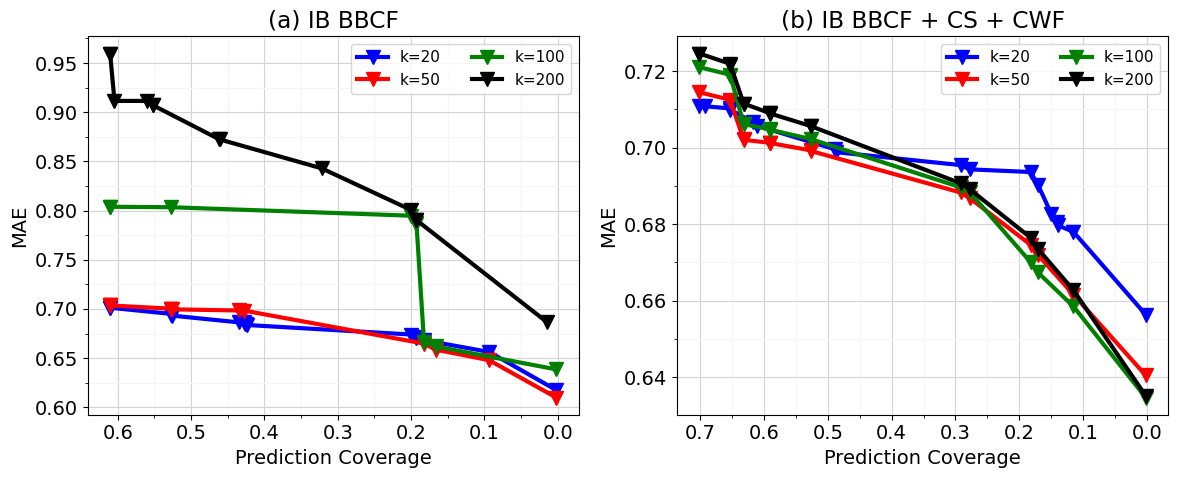

In [34]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)

objectives = [PredictionCoverageStrategy, MAEStrategy]

algorithm_list = [("IB BBCF", IB_BBCF_VANILLA), ("IB BBCF + CS + CWF", IB_BBCF_COSINE_DOUBLE_WEIGHT)]


fixed_parameters = [
    {"knn_k": 20},
    {"knn_k": 50},
    {"knn_k": 100},
    {"knn_k": 200},
]

labels = ["k=20", "k=50", "k=100", "k=200"]
colors = ["blue", "red", "green", "black"]

for alg_id, (name, algorithm) in enumerate(algorithm_list):

    filtered = []
    for fixed_parameter in fixed_parameters:
        filtered.append(filter_solutions(algorithm, fixed_parameter))

    paretos = []
    for filtered in filtered:
        pareto_frontier, _ = get_pareto_frontier(filtered, objectives)
        paretos.append(pareto_frontier)

    for pareto, label, color in zip(paretos, labels, colors):

        add_frontier(axis[alg_id], pareto, color, label, objectives, makers=True)

        if objectives[0].is_better_higher():
            axis[alg_id].invert_xaxis()

        if objectives[1].is_better_higher():
            axis[alg_id].invert_yaxis()

    axis[alg_id].set_xlabel(pretty_names[objectives[0].get_name()])
    axis[alg_id].set_ylabel(pretty_names[objectives[1].get_name()])

    axis[alg_id].legend(loc="upper right", ncol=2, fontsize=11)
    axis[alg_id].xaxis.set_minor_locator(
        ticker.AutoMinorLocator(2)
    )  # Draw 2 minor grid lines per major grid line on the x-axis
    axis[alg_id].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    axis[alg_id].grid(True, which="major", color="lightgray")
    axis[alg_id].grid(True, which="minor", color="whitesmoke")

    if objectives[0].is_better_higher():
        axis[alg_id].invert_xaxis()

    if objectives[1].is_better_higher():
        axis[alg_id].invert_yaxis()


    axis[alg_id].set_title(f"(a) {name}" if alg_id == 0 else f"(b) {name}", loc='center')

    # axis[alg_id].set_title(name)

plt.tight_layout()
# plt.show()
plt.savefig("image.png", dpi=150)


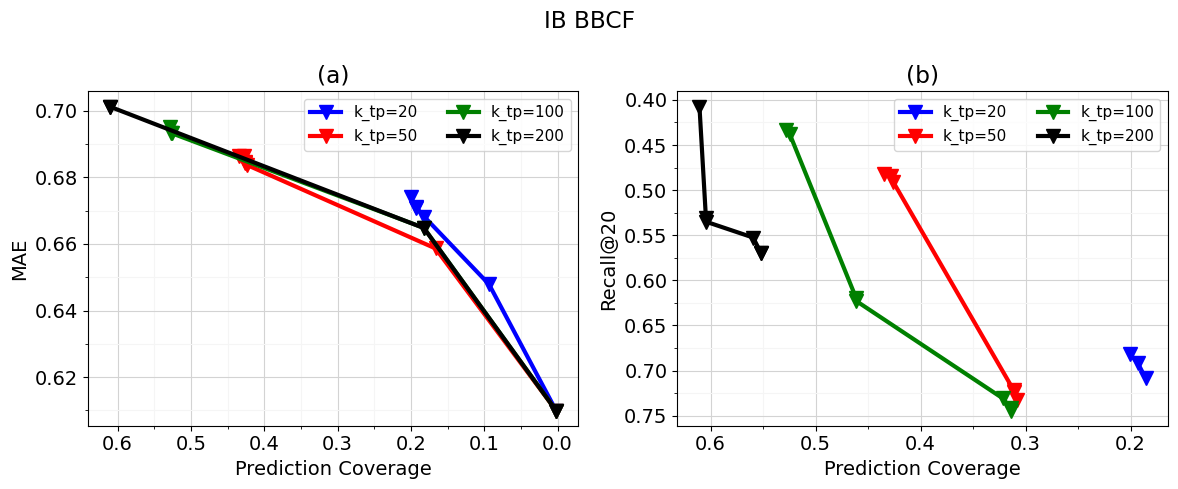

In [36]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)

objectives_list = [
    [PredictionCoverageStrategy, MAEStrategy],
    [PredictionCoverageStrategy, RecallAtKStrategy],
]

fixed_parameters = [
    {"number_of_top_k_biclusters": 10},
    {"number_of_top_k_biclusters": 50},
    {"number_of_top_k_biclusters": 100},
    {"number_of_top_k_biclusters": 200},
]

labels = ["k_tp=20", "k_tp=50", "k_tp=100", "k_tp=200"]
colors = ["blue", "red", "green", "black"]


for alg_id, objectives in enumerate(objectives_list):

    filtered = []
    for fixed_parameter in fixed_parameters:
        filtered.append(filter_solutions(IB_BBCF_VANILLA, fixed_parameter))

    paretos = []
    for filtered in filtered:
        pareto_frontier, _ = get_pareto_frontier(filtered, objectives)
        paretos.append(pareto_frontier)

    for pareto, label, color in zip(paretos, labels, colors):

        add_frontier(axis[alg_id], pareto, color, label, objectives, True)

        # add_scatter(axis[alg_id], pareto, color, "", objectives)

        if objectives[0].is_better_higher():
            axis[alg_id].invert_xaxis()

        if objectives[1].is_better_higher():
            axis[alg_id].invert_yaxis()

    axis[alg_id].set_xlabel(pretty_names[objectives[0].get_name()])
    axis[alg_id].set_ylabel(pretty_names[objectives[1].get_name()])


    axis[alg_id].legend(loc="upper right", ncol=2, fontsize=11)
    axis[alg_id].xaxis.set_minor_locator(
        ticker.AutoMinorLocator(2)
    )  # Draw 2 minor grid lines per major grid line on the x-axis
    axis[alg_id].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
    axis[alg_id].grid(True, which="major", color="lightgray")
    axis[alg_id].grid(True, which="minor", color="whitesmoke")

    if objectives[0].is_better_higher():
        axis[alg_id].invert_xaxis()

    if objectives[1].is_better_higher():
        axis[alg_id].invert_yaxis()

    axis[alg_id].set_title("(a)" if alg_id == 0 else "(b)", loc='center')



fig.suptitle("IB BBCF")
plt.tight_layout()
# plt.show()
plt.savefig("image.png", dpi=150)


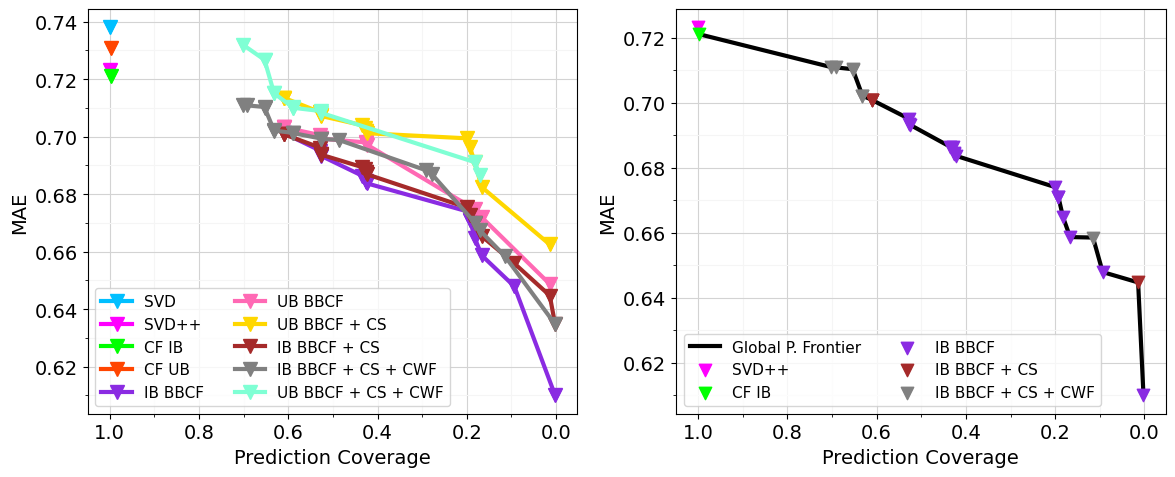

In [39]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)

objectives = [PredictionCoverageStrategy, MAEStrategy]
algorithm_list = [
    ("SVD", SVD),
    ("SVD++", SVDpp),
    ("CF IB", IBKNN),
    ("CF UB", UBKNN),
    ("IB BBCF", IB_BBCF_VANILLA),
    ("UB BBCF", UB_BBCF_VANILLA),
    ("UB BBCF + CS", UB_BBCF_COSINE),
    ("IB BBCF + CS", IB_BBCF_COSINE),
    ("IB BBCF + CS + CWF", IB_BBCF_COSINE_DOUBLE_WEIGHT),
    ("UB BBCF + CS + CWF", UB_BBCF_COSINE_DOUBLE_WEIGHT),
]

for name, algorithm in algorithm_list:

    pareto_frontier, _ = get_pareto_frontier(algorithm, objectives)
    add_frontier(axis[0], pareto_frontier, color_map[name], name, objectives, True)
    add_scatter(axis[0], pareto_frontier, color_map[name], "", objectives)


axis[0].set_xlabel(pretty_names[objectives[0].get_name()])
axis[0].set_ylabel(pretty_names[objectives[1].get_name()])

axis[0].legend(loc="lower left", ncol=2, fontsize=11)
axis[0].xaxis.set_minor_locator(
    ticker.AutoMinorLocator(2)
)  # Draw 2 minor grid lines per major grid line on the x-axis
axis[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axis[0].grid(True, which="major", color="lightgray")
axis[0].grid(True, which="minor", color="whitesmoke")

if objectives[0].is_better_higher():
    axis[0].invert_xaxis()

if objectives[1].is_better_higher():
    axis[0].invert_yaxis()





combined_pareto_frontier, _ = get_pareto_frontier(combined_solutions, objectives)

sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, labels)

add_frontier(axis[1], combined_pareto_frontier, "black", "Global P. Frontier", objectives)

for label, pareto in sorted_pareto.items():
    if len(pareto) > 0:
        add_scatter(axis[1], pareto, color_map[label], label, objectives)

if objectives[0].is_better_higher():
    axis[1].invert_xaxis()

if objectives[1].is_better_higher():
    axis[1].invert_yaxis()

axis[1].set_xlabel(pretty_names[objectives[0].get_name()])
axis[1].set_ylabel(pretty_names[objectives[1].get_name()])

axis[1].legend(loc="lower left", ncol=2, fontsize=11)
axis[1].xaxis.set_minor_locator(
    ticker.AutoMinorLocator(2)
)  # Draw 2 minor grid lines per major grid line on the x-axis
axis[1].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axis[1].grid(True, which="major", color="lightgray")
axis[1].grid(True, which="minor", color="whitesmoke")

plt.tight_layout()
# plt.show()
plt.savefig("image.png", dpi=150)

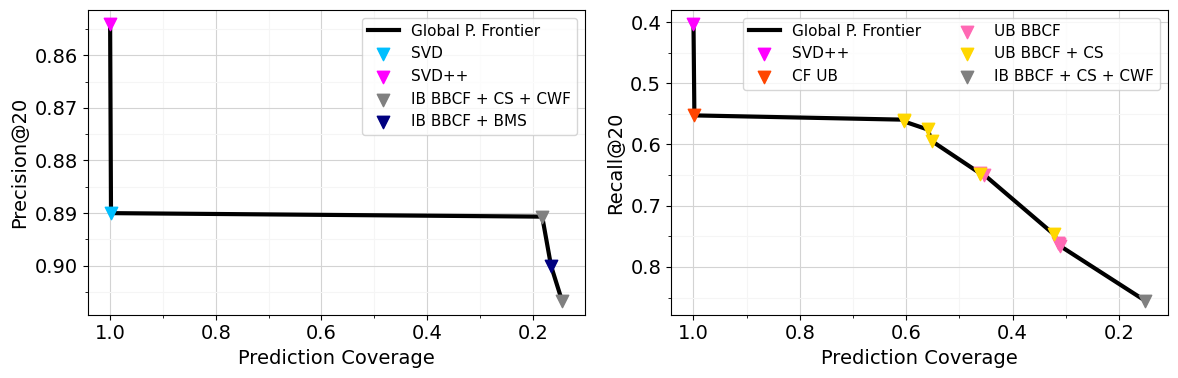

In [27]:
fig, axis = plt.subplots(1, 2, figsize=figure_size)

objectives = [PredictionCoverageStrategy, PrecisionAtKStrategy]

algorithm_list = [
    ("SVD", SVD),
    ("SVD++", SVDpp),
    ("CF IB", IBKNN),
    ("CF UB", UBKNN),
    ("IB BBCF", IB_BBCF_VANILLA),
    ("UB BBCF", UB_BBCF_VANILLA),
    ("UB BBCF + CS", UB_BBCF_COSINE),
    ("IB BBCF + CS", IB_BBCF_COSINE),
    ("IB BBCF + CS + CWF", IB_BBCF_COSINE_DOUBLE_WEIGHT),
    ("UB BBCF + CS + CWF", UB_BBCF_COSINE_DOUBLE_WEIGHT),
    ("IB BBCF + BMS", IB_BBCF_BINAPS),
    ("UB BBCF + BMS", UB_BBCF_BINAPS),
]

combined_pareto_frontier, _ = get_pareto_frontier(combined_solutions, objectives)
sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, labels)
add_frontier(axis[0], combined_pareto_frontier, "black", "Global P. Frontier", objectives)

for label, pareto in sorted_pareto.items():
    if len(pareto) > 0:
        add_scatter(axis[0], pareto, color_map[label], label, objectives)

if objectives[0].is_better_higher():
    axis[0].invert_xaxis()

if objectives[1].is_better_higher():
    axis[0].invert_yaxis()


axis[0].set_xlabel(pretty_names[objectives[0].get_name()])
axis[0].set_ylabel(pretty_names[objectives[1].get_name()])

axis[0].legend(loc="upper right", ncol=1, fontsize=11)
axis[0].xaxis.set_minor_locator(
    ticker.AutoMinorLocator(2)
)  # Draw 2 minor grid lines per major grid line on the x-axis
axis[0].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axis[0].grid(True, which="major", color="lightgray")
axis[0].grid(True, which="minor", color="whitesmoke")




objectives = [PredictionCoverageStrategy, RecallAtKStrategy]


combined_pareto_frontier, _ = get_pareto_frontier(combined_solutions, objectives)
sorted_pareto = sort_pareto_frontier(combined_pareto_frontier, labels)

add_frontier(axis[1], combined_pareto_frontier, "black", "Global P. Frontier", objectives)

for label, pareto in sorted_pareto.items():
    if len(pareto) > 0:
        add_scatter(axis[1], pareto, color_map[label], label, objectives)

if objectives[0].is_better_higher():
    axis[1].invert_xaxis()

if objectives[1].is_better_higher():
    axis[1].invert_yaxis()

axis[1].set_xlabel(pretty_names[objectives[0].get_name()])
axis[1].set_ylabel(pretty_names[objectives[1].get_name()])

axis[1].legend(loc="upper right", ncol=2, fontsize=11)
axis[1].xaxis.set_minor_locator(
    ticker.AutoMinorLocator(2)
)  # Draw 2 minor grid lines per major grid line on the x-axis
axis[1].yaxis.set_minor_locator(ticker.AutoMinorLocator(2))
axis[1].grid(True, which="major", color="lightgray")
axis[1].grid(True, which="minor", color="whitesmoke")

plt.tight_layout()
# plt.show()
plt.savefig("image.png", dpi=100, bbox_inches='tight', pad_inches = 0.01)
